# Прогноз температуры плавления стали

Металлургический комбинат ООО «Так закаляем сталь» с целью оптимизации производственных расходы, решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры;
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец **key** содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# План работы

**1. Проведение обзора данных (EDA)**

**Подготовка данных:** 
* Импорт необходимых библиотек;
* Чтение файлов и получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости).

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков / удаление дубликатов (при наличии);
* Выделение признаков и таргета;
* Соединение таблиц.

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Обучение модели линейной регрессии;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Выбор лучшей модели (по метрике MAE) 

**Тестирование модели:**
* Проверка лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.

**3. Общий вывод**

## Подготовка и анализ данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [2]:
random_state = 28102922
cv_counts = 5

### Чтение файлов и получение общей информации о таблицах

#### Данные об электродах

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(data_arc.head())
display(data_arc.info())
display(data_arc.describe())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Корректировка наименований столбцов

In [4]:
data_arc = data_arc.rename(columns={'key': 'key', 'Начало нагрева дугой': 'start_heating',
                                   'Конец нагрева дугой': 'end_heating', 'Активная мощность': 'active_power',
                                   'Реактивная мощность': 'reactive_power'})

<AxesSubplot:>

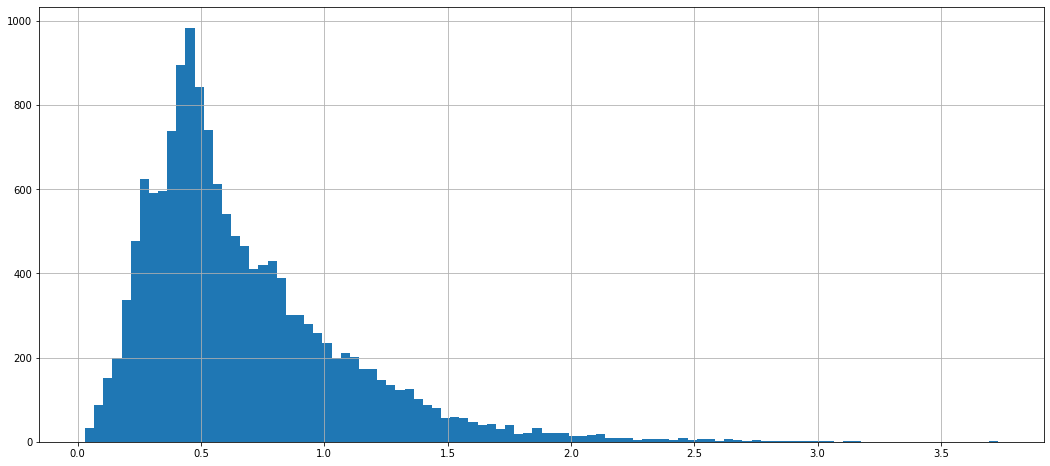

In [5]:
data_arc['active_power'].hist(bins=100, figsize=(18,8))

<AxesSubplot:>

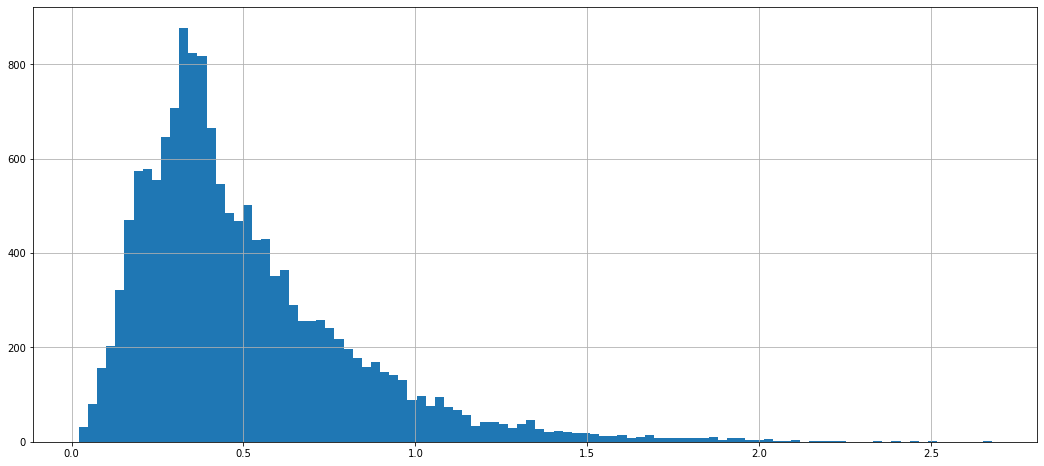

In [6]:
data_arc[data_arc['reactive_power'] > 0]['reactive_power'].hist(bins=100, figsize=(18,8))

In [7]:
len(data_arc['key'].unique())

3214

#### Данные о подаче сыпучих материалов (объём)

In [8]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(data_bulk.head())
display(data_bulk.info())
display(data_bulk.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [9]:
def histog(data, column):
    return data[column].hist(bins=100, figsize=(9,4))

<AxesSubplot:>

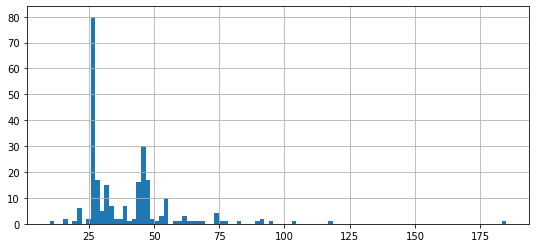

In [10]:
histog(data_bulk, 'Bulk 1')

<AxesSubplot:>

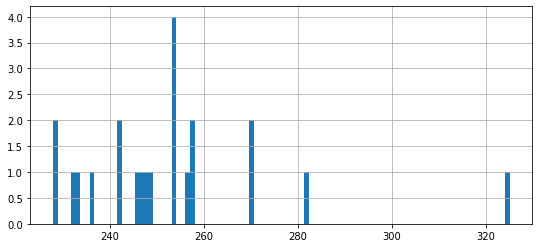

In [11]:
histog(data_bulk, 'Bulk 2')

<AxesSubplot:>

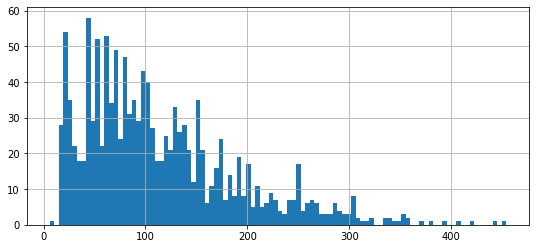

In [12]:
histog(data_bulk, 'Bulk 3')

<AxesSubplot:>

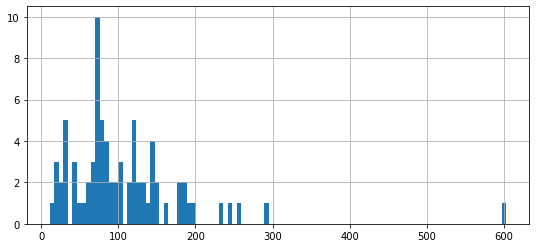

In [13]:
histog(data_bulk, 'Bulk 5')

<AxesSubplot:>

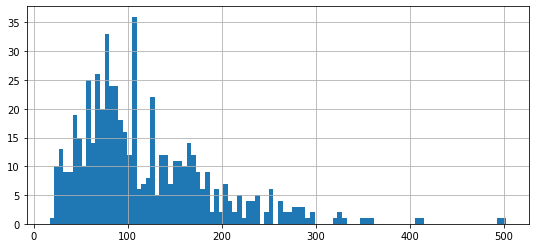

In [14]:
histog(data_bulk, 'Bulk 6')

<AxesSubplot:>

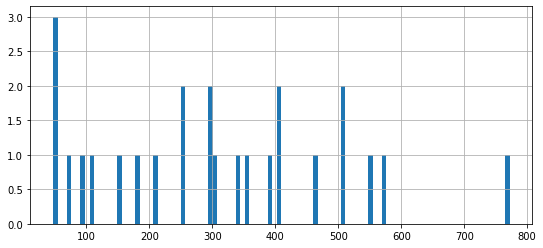

In [15]:
histog(data_bulk, 'Bulk 7')

<AxesSubplot:>

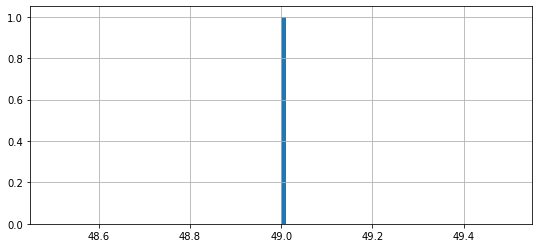

In [16]:
histog(data_bulk, 'Bulk 8')

<AxesSubplot:>

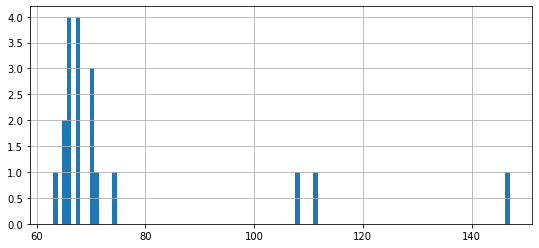

In [17]:
histog(data_bulk, 'Bulk 9')

<AxesSubplot:>

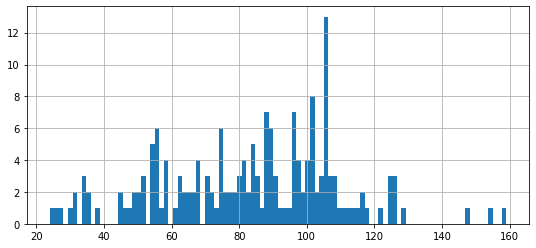

In [18]:
histog(data_bulk, 'Bulk 10')

<AxesSubplot:>

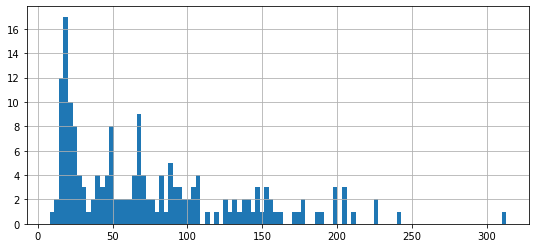

In [19]:
histog(data_bulk, 'Bulk 11')

<AxesSubplot:>

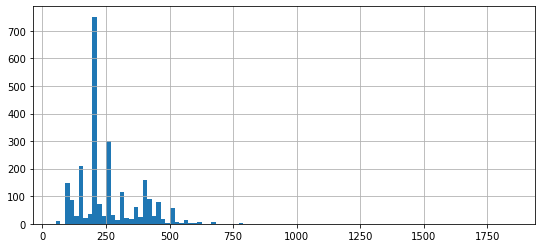

In [20]:
histog(data_bulk, 'Bulk 12')

<AxesSubplot:>

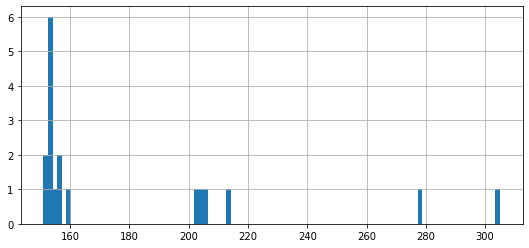

In [21]:
histog(data_bulk, 'Bulk 13')

<AxesSubplot:>

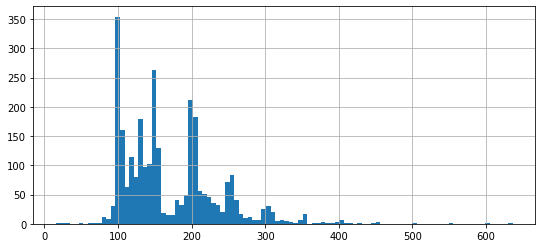

In [22]:
histog(data_bulk, 'Bulk 14')

<AxesSubplot:>

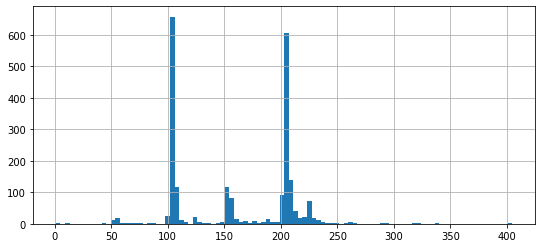

In [23]:
histog(data_bulk, 'Bulk 15')

In [24]:
len(data_bulk['key'].unique())

3129

#### Данные о подаче сыпучих материалов (время)

In [25]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(data_bulk_time.head())
display(data_bulk_time.info())
display(data_bulk_time.describe())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [26]:
len(data_bulk_time['key'].unique())

3129

#### Данные о продувке сплава газом

In [27]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(data_gas.head())
display(data_gas.info())
display(data_gas.describe())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Корректировка наименований столбцов

In [28]:
data_gas = data_gas.rename(columns={'key': 'key', 'Газ 1': 'gas'})

<AxesSubplot:>

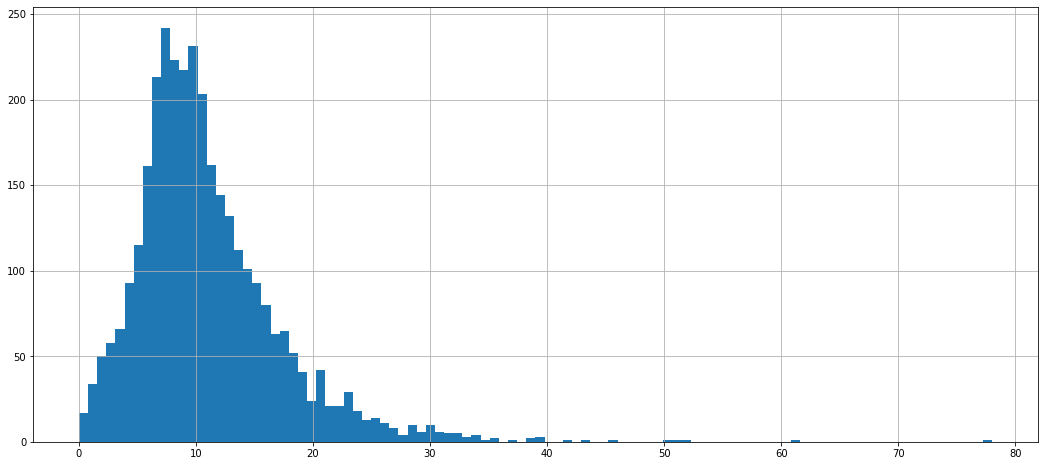

In [29]:
data_gas['gas'].hist(bins=100, figsize=(18,8))

#### Результаты измерения температуры

In [30]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(data_temp.head())
display(data_temp.info())
display(data_temp.describe())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Корректировка наименований столбцов

In [31]:
data_temp = data_temp.rename(columns={'key': 'key', 'Время замера': 'measure_time', 'Температура': 'temp'})

In [32]:
data_temp.head()

,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Удалим партии с температурой ниже 1400 градусов

In [33]:
list_bad_temp = list(data_temp.query('temp < 1400')['key'].values)
data_temp = data_temp.query('key != @list_bad_temp')

In [34]:
list_bad_temp

[867, 1214, 1619, 1818, 1818, 2052, 2561]

#### Данные о проволочных материалах (объём)

In [35]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(data_wire.head())
display(data_wire.info())
display(data_wire.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


#### Данные о проволочных материалах (время)

In [36]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(data_wire_time.head())
display(data_wire_time.info())
display(data_wire_time.describe())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


### Вывод

Данные изучены. Выявлены следующие аномалии:

- Пропуски значений в столбцах
- Разное количество уникальных значений key
- Именование столбцов на разных языках
- Несоответсвующий тип данных
- Аномальное значение реактивной мощности в таблице data_arc.

Данные требуют предобработки и группировки по признаку key. Данные нормально распределены

## Предобработка данных

Так как целью задания является предсказание температуры стали, целевым признаком для обучения модели будет **финальный замер температуры (end_temp)**. Остальные столбцы будут обучающими признакми

Найдем суммы значений активной и реактивной мощности

In [37]:
data_arc = data_arc.query('reactive_power > 0')
data_arc_sum = pd.pivot_table(data_arc,
                              values=['active_power','reactive_power'],
                              index='key',
                              aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['sum_active_power','sum_reactive_power']
data_arc_sum.head()

,sum_active_power,sum_reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


Необходимо выделить партии в которых есть первое и последнее измерение температуры. Последнее измерение будет целевым признаком и если данных по нему нет, то данные по всей партии будут удалены

In [38]:
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['measure_time'].max() < 
            data_arc[data_arc['key'] == key]['end_heating'].max()) or
           (data_temp[data_temp['key'] == key]['measure_time'].max() == 
            data_temp[data_temp['key'] == key]['measure_time'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key)

In [39]:
data_temp = data_temp.query('key not in @bad_keys')
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15126 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15126 non-null  int64  
 1   measure_time  15126 non-null  object 
 2   temp          12336 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 472.7+ KB


,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Удалим пропуски

In [40]:
data_temp = data_temp.dropna()

In [41]:
data_temp

,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


Удалим из таблицы строки, в которых меньше двух замеров

In [42]:
count_of_bad_keys = (data_temp['key'].value_counts() < 2).sum() 
good_keys = list(data_temp['key'].value_counts().index[:-count_of_bad_keys])
data_temp = data_temp.query('key in @good_keys')

Получим сводную таблицу со значениями первого и последнего замера, чтоб на его основе создать сводную таблицу уже по значениям температур на этих замерах

In [43]:
pt_data_temp = pd.pivot_table(data_temp,
                              values='measure_time',
                              index='key',
                              aggfunc={'measure_time': [np.min, np.max]})
pt_data_temp

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
2495,2019-08-06 00:54:42,2019-08-06 00:35:45
2496,2019-08-06 01:29:52,2019-08-06 01:02:54
2497,2019-08-06 01:53:50,2019-08-06 01:41:53


In [44]:
start_time_list = list(pt_data_temp['amin'])
end_time_list = list(pt_data_temp['amax'])
data_temp_start_temp = data_temp.query('measure_time in @start_time_list ')
data_temp_start_temp = data_temp_start_temp.set_index('key')
data_temp_end_temp = data_temp.query('measure_time in @end_time_list ')
data_temp_end_temp = data_temp_end_temp.set_index('key')
data_temp_final = data_temp_start_temp.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end_temp['temp']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.head()

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [45]:
data_temp_final

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


Объединим таблицы

In [46]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [47]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]

In [48]:
data_steel = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_steel = data_steel.dropna()
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2206 non-null   float64
 1   sum_reactive_power  2206 non-null   float64
 2   start_temp          2206 non-null   float64
 3   end_temp            2206 non-null   float64
 4   bulk_1              2206 non-null   float64
 5   bulk_2              2206 non-null   float64
 6   bulk_3              2206 non-null   float64
 7   bulk_4              2206 non-null   float64
 8   bulk_5              2206 non-null   float64
 9   bulk_6              2206 non-null   float64
 10  bulk_7              2206 non-null   float64
 11  bulk_8              2206 non-null   float64
 12  bulk_9              2206 non-null   float64
 13  bulk_10             2206 non-null   float64
 14  bulk_11             2206 non-null   float64
 15  bulk_12             2206 non-null   float64
 16  bulk_1

Столбцы start_temp, end_temp и bulk приведем к типу данных integer

In [49]:
data_steel['start_temp'] = pd.to_numeric(data_steel['start_temp'], downcast='integer')
data_steel['end_temp'] = pd.to_numeric(data_steel['end_temp'], downcast='integer')
for i in range(1,16):
    data_steel[f'bulk_{i}'] = pd.to_numeric(data_steel[f'bulk_{i}'], downcast='integer')
data_steel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sum_active_power    2206 non-null   float64
 1   sum_reactive_power  2206 non-null   float64
 2   start_temp          2206 non-null   int16  
 3   end_temp            2206 non-null   int16  
 4   bulk_1              2206 non-null   int16  
 5   bulk_2              2206 non-null   int16  
 6   bulk_3              2206 non-null   int16  
 7   bulk_4              2206 non-null   int16  
 8   bulk_5              2206 non-null   int16  
 9   bulk_6              2206 non-null   int16  
 10  bulk_7              2206 non-null   int16  
 11  bulk_8              2206 non-null   int8   
 12  bulk_9              2206 non-null   int16  
 13  bulk_10             2206 non-null   int16  
 14  bulk_11             2206 non-null   int16  
 15  bulk_12             2206 non-null   int16  
 16  bulk_1

<AxesSubplot:>

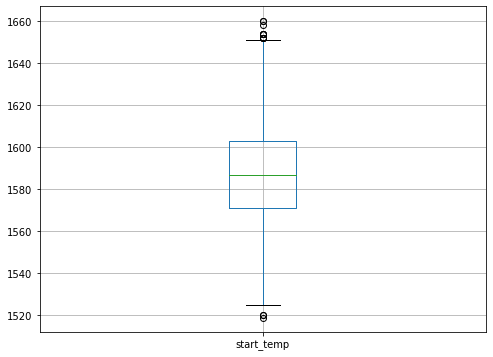

In [50]:
data_steel.boxplot(column='start_temp', figsize=(8,6))

<AxesSubplot:>

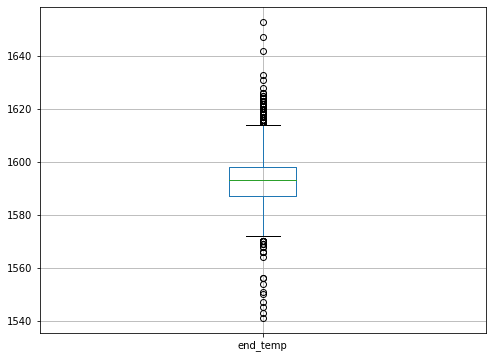

In [51]:
data_steel.boxplot(column='end_temp', figsize=(8,6))

<AxesSubplot:>

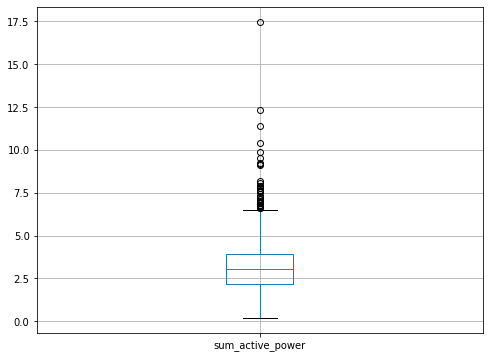

In [52]:
data_steel.boxplot(column='sum_active_power', figsize=(8,6))

<AxesSubplot:>

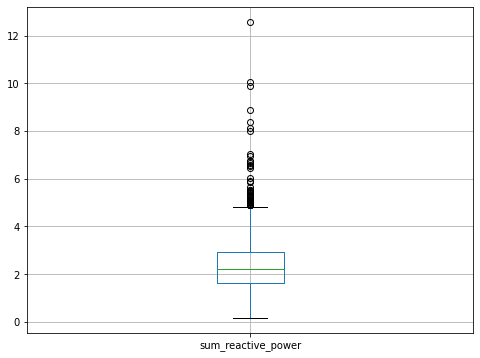

In [53]:
data_steel.boxplot(column='sum_reactive_power', figsize=(8,6))

<AxesSubplot:>

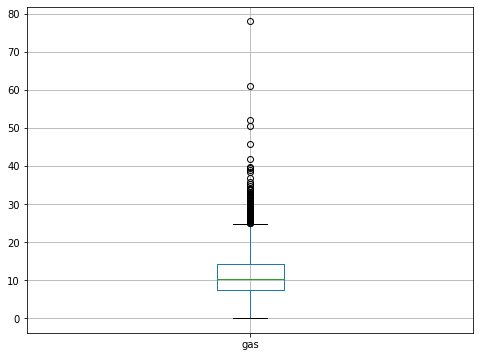

In [54]:
data_steel.boxplot(column='gas', figsize=(8,6))

Посмотрим на корреляцию признаков

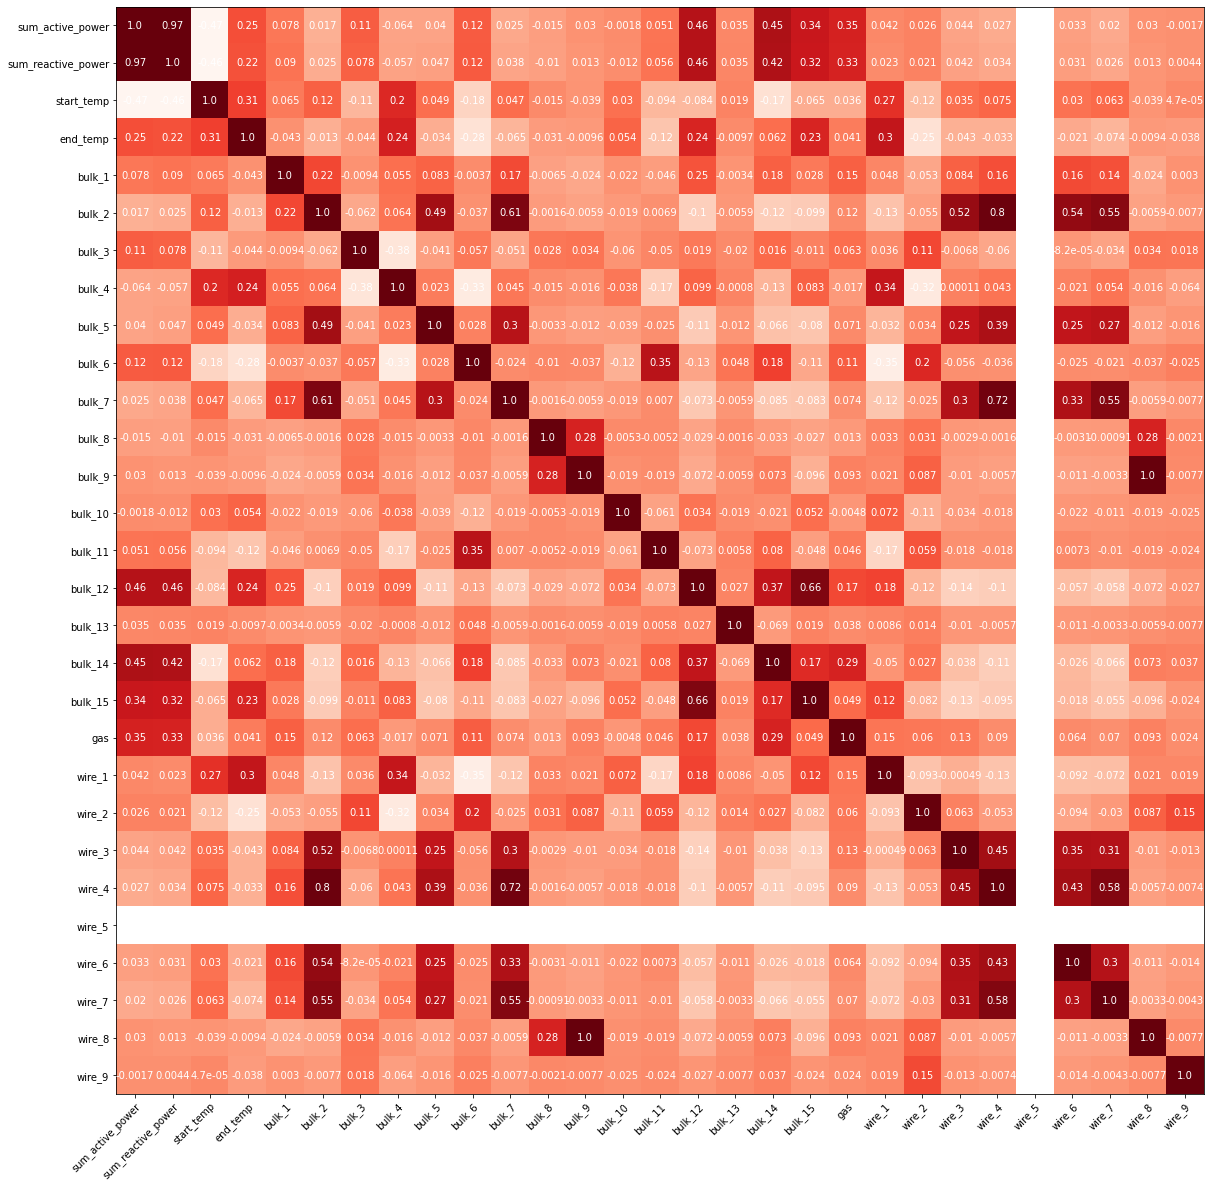

In [55]:
corr_heatmap_data = data_steel.corr(method='spearman')

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_data.index)))
ax.set_yticks(np.arange(len(corr_heatmap_data.index)))

ax.set_xticklabels(corr_heatmap_data.index)
ax.set_yticklabels(corr_heatmap_data.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_data.values

for i in range(len(corr_heatmap_data.index)):
    for j in range(len(corr_heatmap_data.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_data.corr(), cmap='Reds')

Наблюдается сильная зависимость между sum_active_power и sum_reactive_power и bulk_9 и wire_8. Удалим sum_reactive_power и wire_8.

In [56]:
data_steel = data_steel.drop(['sum_reactive_power', 'wire_8', 'wire_5'], axis=1)

Посмотрим, какие признаки оказывают сильное влияние на целевой. Отберем с влиянием более 0.2

In [57]:
data_steel.corr()['end_temp'].abs() > 0.2

sum_active_power     True
start_temp           True
end_temp             True
bulk_1              False
bulk_2              False
bulk_3              False
bulk_4              False
bulk_5              False
bulk_6              False
bulk_7              False
bulk_8              False
bulk_9              False
bulk_10             False
bulk_11             False
bulk_12              True
bulk_13             False
bulk_14             False
bulk_15              True
gas                 False
wire_1               True
wire_2               True
wire_3              False
wire_4              False
wire_5              False
wire_6              False
wire_7              False
wire_9              False
Name: end_temp, dtype: bool

In [58]:
data_steel

,sum_active_power,start_temp,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,4.878147,1571,1613,0,0,0,43,0,0,0,...,154,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3.052598,1581,1602,0,0,0,73,0,0,0,...,154,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,2.525882,1596,1599,0,0,0,34,0,0,0,...,153,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,3.209250,1601,1625,0,0,0,81,0,0,0,...,154,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
5,3.347173,1576,1602,0,0,0,78,0,0,0,...,152,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.210690,1570,1591,0,0,21,0,0,0,0,...,223,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2496,4.203064,1554,1591,0,0,0,63,0,0,0,...,226,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2497,2.212379,1571,1589,0,0,0,85,0,0,0,...,226,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0


###  Вывод

В ходе предобработки выполнено следующее
- Выявлен целевой признак - финальный замер температуры 
- Данные очищены от аномалий
- Составлена своднаяа таблица для обучения модели

Данные готовы к дальнейшей работе

## Построение модели машинного обучения

### Разделение данных на обучающую и тестовую выборки

In [59]:
features = data_steel.drop('end_temp', axis=1)
target = data_steel['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=random_state)

**Для обучения выбраны следующие модели:**
- **LinearRegression**
- **RandomForestRegressor**
- **LGBMRegressor**
- **XGBRegressor**

###  LinearRegression

In [60]:
%%time

model_lr = LinearRegression()
lr_mae = (cross_val_score(model_lr, features_train, target_train, cv=cv_counts, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('LinearRegression MAE =', lr_mae)

LinearRegression MAE = 6.810084354682729
CPU times: user 76.8 ms, sys: 123 ms, total: 200 ms
Wall time: 143 ms


Проверим влияние масштабирования признаков на качество модели

In [61]:
%%time

model_lr = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([('standard_scaller', scaller),('linear_regression', model_lr)])
slr_mae = (cross_val_score(pipeline, features_train, target_train, cv=cv_counts, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('Scaled LinearRegression MAE =', slr_mae)

Scaled LinearRegression MAE = 6.810084354682729
CPU times: user 203 ms, sys: 261 ms, total: 464 ms
Wall time: 494 ms


Масштабирование признаков не влияет на качество модели

###  RandomForestRegressor

In [62]:
%%time

model_rfr = RandomForestRegressor() 
parameters = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 1001, 50)], 
                'random_state':[random_state]}]
grid_rfr = GridSearchCV(model_rfr, parameters, scoring='neg_mean_absolute_error', cv=cv_counts)
grid_rfr.fit(features_train, target_train)
best_params_RFR = grid_rfr.best_params_
print(grid_rfr.best_params_)

{'criterion': 'mse', 'n_estimators': 800, 'random_state': 28102922}
CPU times: user 6min 2s, sys: 1.55 s, total: 6min 4s
Wall time: 6min 4s


In [71]:
%%time

model_rfr = RandomForestRegressor(criterion = "mse", random_state=random_state, n_estimators = 800)
rfr_mae = (cross_val_score(model_rfr, features_train, target_train, cv=cv_counts, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('RandomForestRegressor MAE =', rfr_mae)

RandomForestRegressor MAE = 6.182879925386797
CPU times: user 27.2 s, sys: 260 ms, total: 27.5 s
Wall time: 27.5 s


### LGBMRegressor

In [64]:
%%time

model_lgbm = LGBMRegressor() 
parameters = [{'num_leaves':[10,12,14,16], 
                'learning_rate':[0.02,0.04,0.06],
                'random_state':[random_state]}]
grid_lgbm = GridSearchCV(model_lgbm, parameters, scoring='neg_mean_absolute_error', cv=cv_counts)
grid_lgbm.fit(features_train, target_train)
print(grid_lgbm.best_params_)

{'learning_rate': 0.04, 'num_leaves': 16, 'random_state': 28102922}
CPU times: user 37.5 s, sys: 248 ms, total: 37.7 s
Wall time: 38.3 s


In [72]:
%%time

model_lgbm = LGBMRegressor(random_state=random_state, num_leaves = 16, learning_rate = 0.04)
lgbm_mae = (cross_val_score(model_lgbm, features_train, target_train, cv=cv_counts, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('LGBMRegressor MAE =', lgbm_mae)

LGBMRegressor MAE = 6.064802426698826
CPU times: user 3.73 s, sys: 19.8 ms, total: 3.75 s
Wall time: 3.76 s


### XGBRegressor

In [66]:
%%time

model_xgb = XGBRegressor() 
parameters = [{'learning_rate':[x/100 for x in range(1, 31)],
                'random_state':[random_state],
                }]
grid_xgb = GridSearchCV(model_xgb, parameters, scoring='neg_mean_absolute_error', cv=cv_counts)
grid_xgb.fit(features_train, target_train)
print(grid_xgb.best_params_)

{'learning_rate': 0.08, 'random_state': 28102922}
CPU times: user 10min 10s, sys: 4.13 s, total: 10min 14s
Wall time: 10min 20s


In [73]:
%%time

model_xgb = XGBRegressor(random_state=random_state, learning_rate = 0.08)
xgb_mae = (cross_val_score(model_xgb, features_train, target_train, cv=cv_counts, 
                          scoring='neg_mean_absolute_error').mean() * -1)
print('XGBRegressor MAE =', xgb_mae)

XGBRegressor MAE = 6.008204174041748
CPU times: user 20.1 s, sys: 151 ms, total: 20.2 s
Wall time: 20.4 s


In [74]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'LGBMRegressor',
         'XGBRegressor']
data = {'MAE на CV':[lr_mae,
                     rfr_mae,
                     lgbm_mae,
                     xgb_mae]}

scores = pd.DataFrame(data=data, index=index)
scores

,MAE на CV
LinearRegression,6.810084
RandomForestRegressor,6.182880
LGBMRegressor,6.064802
XGBRegressor,6.008204


## Тестирование лучшей модели

In [75]:
%%time

best_model = XGBRegressor(random_state=random_state, silent = True, learning_rate = 0.08)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
test_xgb_mae = mean_absolute_error(predictions, target_test)
print('XGBRegressor MAE =', test_xgb_mae)

[22:33:10] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBRegressor MAE = 5.6659384
CPU times: user 2.94 s, sys: 3.77 ms, total: 2.94 s
Wall time: 2.92 s


## Общий вывод

В ходе работы было выполнено следующее:

- Подготовка данных. Отобраны те партии, в которых есть значения первого и последнего замера температуры.
- Составление сводной таблицы со всеми необходимыми для модели данными. Целевым признаком выбрана температура последнего замера
- Обучение нескольких регрессионных моделей
- Выбор лучшей модели
- Тестирование лучшей модели

Лучшей моделью по метрике MAE со значением 5.66 стал XGBRegressor. Хорошо себя показали LGBMRegressor и RandomForestRegressor. Линейная регрессия показала себя хуже остальных моделей и меньше всех подходит для выполнения поставленной задачи

**График важности признаков**

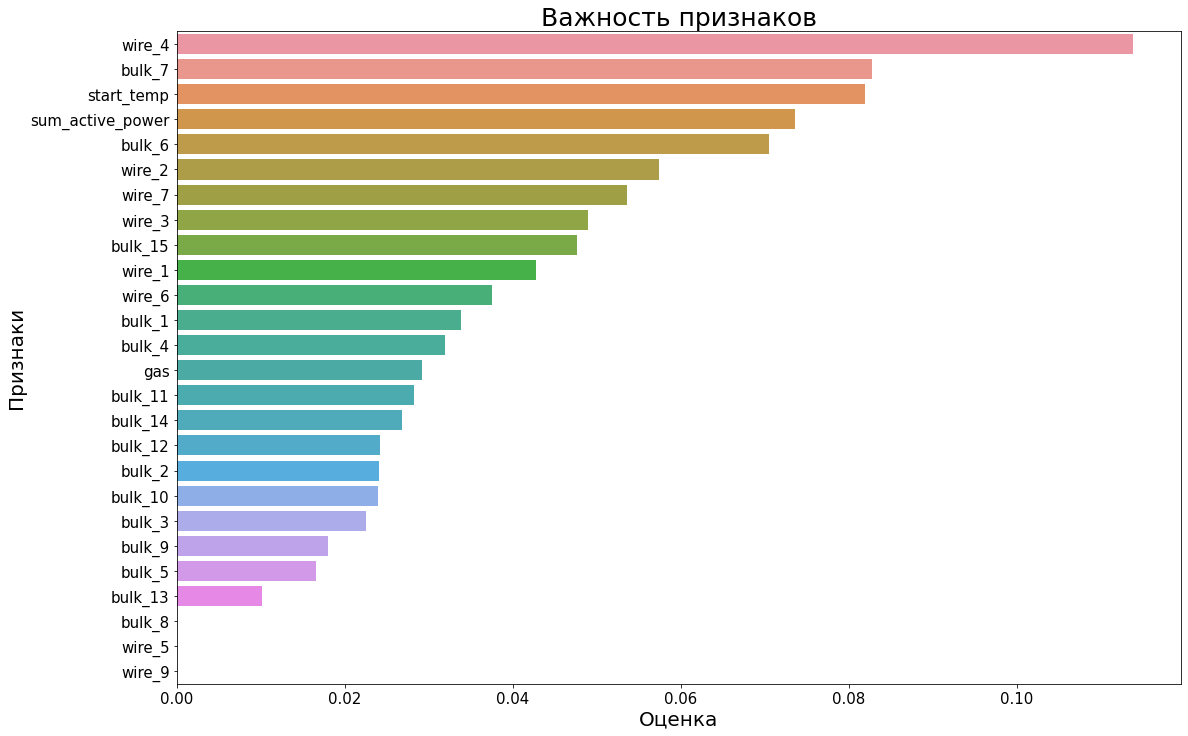

In [76]:
def feature_importance(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(18, 12))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)     
    ax.set_xlabel('Оценка', fontsize=20)
    ax.set_ylabel('Признаки', fontsize=20)
    ax.set_title('Важность признаков', fontsize=25)
    ax.tick_params(axis = 'both', labelsize = 15)

feature_importance(best_model)

По графику важности видно, что наибольшее влияние на целевой оказывает количество проволочных материалов(в топ-10 целых 5 признаков), начальнаая температура и активная мощность

# Отчёт по решению задачи

## Условие задачи

Металлургическим комбинатом ООО «Так закаляем сталь» была поставлена задача: Спрогнозировать температуру стали с целью уменьшения потребления электроэнергии на этапе обработки.

Для выполнения этой задачи, необходимо построить модель, которая будет предсказывать температуру стали на последнем этапе обработки.

Были предоставлены необходимые данные для обучения модели и описан этап обработки стали.

## Описание решения

Решение задачи начинается с составления плана работы. План включает следующие этапы:

**1. Проведение обзора данных**

- Подготовка данных
- Анализ данных
- Предобработка данных

**2. Построение модели машинного обучения**

- Обучение моделей
- Тестирование лучшей модели

Первый этап является очень важной частью работы. На данном этапе данные подготавливаются для работы с моделями машинного обучения. Выявляется целевой признак для обучения.

В ходе работ на первом этапе выполнено следующее:
- "очистка" данных от аномальных значений и пропусков
- объединение данных в общую таблицу
- выявление целевого признака (финального замера температуры)
- фильтрация данных по значению целевого признака (удаление партий без финального замера температур)
- проверка признаков на мультиколлинеарность (зависимость)

Второй этап работы можно назвать подбором решения поставленной задачи. На данном этапе обучались модели и среди них выбиралась лучшая 

В ходе работ на втором этапе выполнено следующее:
- разделение данных на обучающую и тестовую выборки
- обучение нескольких моделей (LinearRegression, RandomForestRegressor, LGBMRegressor, XGBRegressor)
- подбор лучших параметров для каждой модели
- тестирование лучшей модели
- оценка важности признаков для лучшей модели

## Результат

**Лучшей моделью по метрике MAE со значением 5.66 стал XGBRegressor ({'learning_rate': 0.08, 'random_state': 28102922}). MAE показывает, что данная модель в среднем ошибается на 5.66 градусов температуры, что является хорошим результатом.**

**Наибольшее влияние на финальный замер температуры оказывает количество проволочных материалов (в топ-10 целых 5 признаков), начальнаая температура и активная мощность**

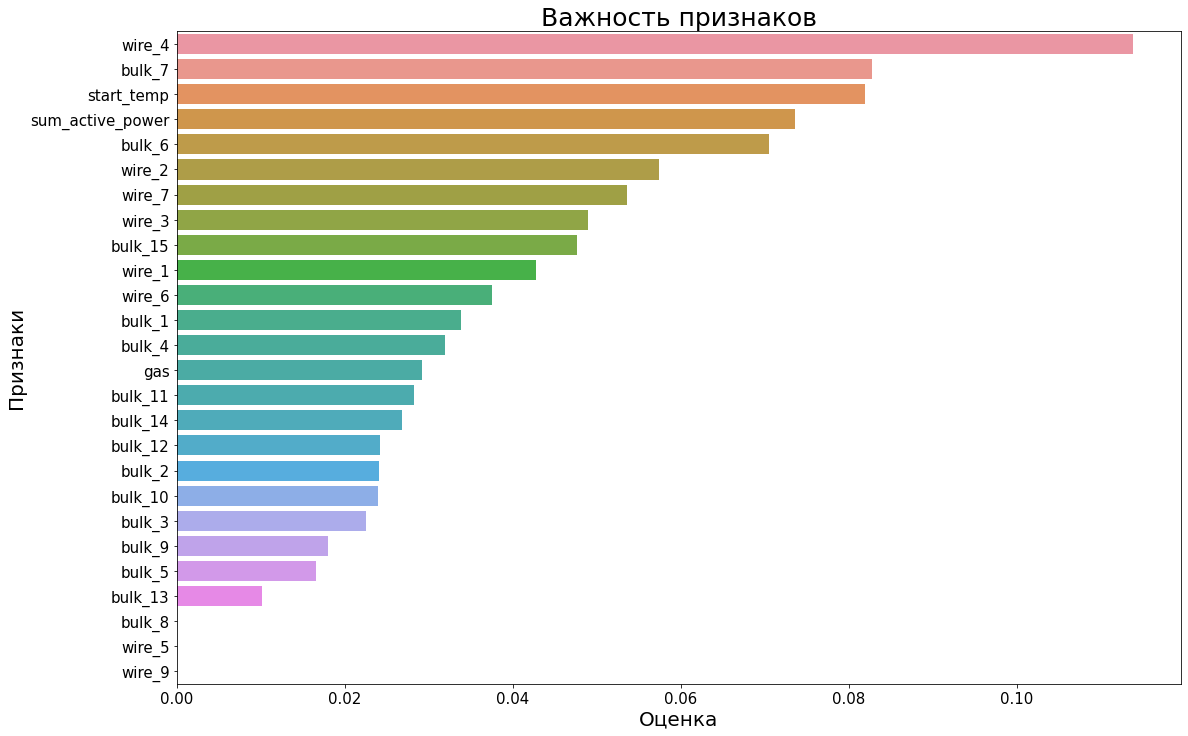